In [1]:
# Data Pre-Processing
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [2]:
import pandas as pd
dataset = pd.read_excel("full.xlsx")

In [3]:
print("Head: \n")
dataset.head()

Head: 



,Unnamed: 0,Text,Main_Class,Sub_Class,Dataset
0,0,month huluplus gift huluplus cod worth send wi...,Services,Hacking,NaN
1,1,pay tv sky uk sky germany hd tv much cccam ser...,Services,Hacking,NaN
2,2,official account creator extreme submission fi...,Services,Hacking,NaN
3,3,vpn tor sock tutorialhow setup vpn tor sock su...,Services,Hacking,NaN
4,4,facebook hack guide guide teach hack facebook ...,Services,Hacking,NaN


In [4]:
print("Description: \n")
dataset.describe()

Description: 



,Unnamed: 0
count,114085.000000
mean,57042.000000
std,32933.647068
min,0.000000
25%,28521.000000
50%,57042.000000
75%,85563.000000
max,114084.000000


In [5]:
# Cleaning dataset

In [6]:
dataset = dataset.drop(columns=['Sub_Class', 'Dataset'])

In [7]:
dataset = dataset.dropna()

In [8]:
dataset.describe()

,Unnamed: 0
count,113835.000000
mean,57058.099337
std,32916.101867
min,0.000000
25%,28550.500000
50%,57063.000000
75%,85561.500000
max,114084.000000


In [9]:
# Re-rewriting Main class to use number instead of names

In [35]:
CLASS_NAMES = {}
CLASS_INDEX = {}
label_names = []
for idx, name in enumerate(dataset.Main_Class.value_counts().index.tolist()):
    CLASS_NAMES[idx] = name
    CLASS_INDEX[name] = idx
    label_names.append(name)

In [11]:
dataset['label'] = dataset.Main_Class[:]

In [12]:
dataset['label'] = dataset.label.apply(lambda val: CLASS_INDEX[str(val)])

In [13]:
# Training The Model with Dataset

In [14]:
from sklearn.model_selection import train_test_split

X = dataset.Text
y = dataset.label
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [15]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [16]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [17]:
# x_train
train_input_ids, train_att_masks = encode(x_train.values.tolist())
valid_input_ids, valid_att_masks = encode(x_val.values.tolist())
test_input_ids, test_att_masks = encode(x_test.values.tolist())

In [18]:
import torch
train_y = torch.LongTensor(y_train.values.tolist())
valid_y = torch.LongTensor(y_val.values.tolist())
test_y = torch.LongTensor(y_test.values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([91068]), torch.Size([11384]), torch.Size([11383]))

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [20]:
from transformers import BertForSequenceClassification
N_labels = len(dataset.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model = model.cuda()

In [22]:
# Fine-Tuning

In [23]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 4
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [25]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    # print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(dataset.label) / BATCH_SIZE), train_loss / (step_num + 1)))
    # print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))
model.save_pretrained("mchtcModel/")
tokenizer.save_vocabulary("mchtcModel/")

Epoch:  1


Training:   0%|          | 0/5692 [00:00<?, ?it/s]

Validation:   0%|          | 0/712 [00:00<?, ?it/s]

Epoch:  2


Training:   0%|          | 0/5692 [00:00<?, ?it/s]

Validation:   0%|          | 0/712 [00:00<?, ?it/s]

Epoch:  3


Training:   0%|          | 0/5692 [00:00<?, ?it/s]

Validation:   0%|          | 0/712 [00:00<?, ?it/s]

Epoch:  4


Training:   0%|          | 0/5692 [00:00<?, ?it/s]

Validation:   0%|          | 0/712 [00:00<?, ?it/s]

('mchtcModel/vocab.txt',)

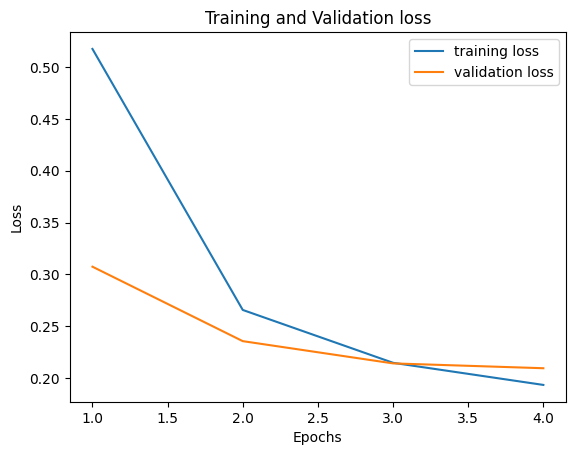

In [26]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [27]:
# Performance Metrics

In [40]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, y_val.to_numpy(), labels=label_names))

classifiation report
                                     precision    recall  f1-score   support

                              Drugs       0.00      0.00      0.00         0
                Library Information       0.00      0.00      0.00         0
               Counterfeit Products       0.00      0.00      0.00         0
               Substances for Drugs       0.00      0.00      0.00         0
                           Services       0.00      0.00      0.00         0
                     Services/Money       0.00      0.00      0.00         0
                           Accounts       0.00      0.00      0.00         0
                Drugs paraphernalia       0.00      0.00      0.00         0
                     Cryptocurrency       0.00      0.00      0.00         0
                           Violence       0.00      0.00      0.00         0
Counterfeit Personal-Identification       0.00      0.00      0.00         0
                        Leaked Data       0.00      0.

D:\sb\kspvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\sb\kspvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\sb\kspvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\sb\kspvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: U

In [29]:
# Error Analysis

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (21).

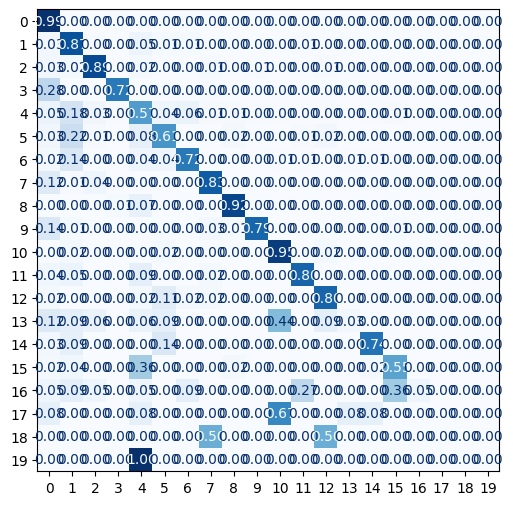

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()
plot_confusion_matrix(valid_pred,y_val.to_numpy(),labels=label_names)


In [31]:
# Prediction on Testing Set

In [43]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)
    

0it [00:00, ?it/s]

In [44]:
print('classifiation report')
print(classification_report(test_pred, y_test.to_numpy(),labels=label_names))

classifiation report
                                     precision    recall  f1-score   support

                              Drugs       0.00      0.00      0.00         0
                Library Information       0.00      0.00      0.00         0
               Counterfeit Products       0.00      0.00      0.00         0
               Substances for Drugs       0.00      0.00      0.00         0
                           Services       0.00      0.00      0.00         0
                     Services/Money       0.00      0.00      0.00         0
                           Accounts       0.00      0.00      0.00         0
                Drugs paraphernalia       0.00      0.00      0.00         0
                     Cryptocurrency       0.00      0.00      0.00         0
                           Violence       0.00      0.00      0.00         0
Counterfeit Personal-Identification       0.00      0.00      0.00         0
                        Leaked Data       0.00      0.

D:\sb\kspvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\sb\kspvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\sb\kspvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\sb\kspvenv\lib\site-packages\sklearn\metrics\_classification.py:1509: U

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (21).

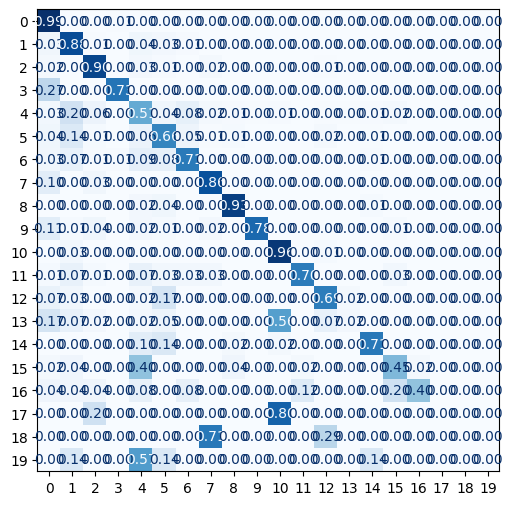

In [45]:
plot_confusion_matrix(test_pred,y_test.to_numpy(),labels=label_names)